In [1]:


import os
import sys
import platform
import gecatsim as xc
from gecatsim.pyfiles.CommonTools import *
from gecatsim.reconstruction.pyfiles import recon
import numpy as np

def Init(inp_file, FOV):
    cfg = CFG()

    # Phantom
    cfg.phantom.callback = "Phantom_Voxelized"      # name of function that reads and models phantom
    cfg.phantom.projectorCallback = "C_Projector_Voxelized" # name of function that performs projection through phantom
    cfg.phantom.filename = 'CatSim_logo_1024.json'  # phantom filename, not actually used in AAPM Recon
    cfg.phantom.centerOffset = [0.0, 0.0, 0.0]      # offset of phantom center relative to origin (in mm)
    cfg.phantom.scale = 1                           # re-scale the size of phantom
    if platform.system() == "Linux":
        cfg.phantom.projectorNumThreads = 4
    elif platform.system() == "Windows":
        cfg.phantom.projectorNumThreads = 1
    else:
        cfg.phantom.projectorNumThreads = 1
    
    # physics
    cfg.physics.energyCount = 20                    # number of energy bins
    cfg.physics.monochromatic = -1                  # -1 for polychromatic (see protocol.cfg);
    cfg.physics.colSampleCount = 1                  # number of samples of detector cells in lateral direction
    cfg.physics.rowSampleCount = 1                  # number of samples of detector cells in longitudinal direction
    cfg.physics.srcXSampleCount = 2                 # number of samples of focal spot in lateral direction
    cfg.physics.srcYSampleCount = 2                 # number of samples of focal spot cells in longitudinal direction
    cfg.physics.viewSampleCount = 2                 # number of samples of each view angle range in rotational direction
    cfg.physics.recalcDet = 0                       # recalculate detector geometry
    cfg.physics.recalcSrc = 0                       # recalculate source geometry and relative intensity
    cfg.physics.recalcRayAngle = 0                  # recalculate source-to-detector-cell ray angles
    cfg.physics.recalcSpec = 0                      # recalculate spectrum
    cfg.physics.recalcFilt = 0                      # recalculate filters
    cfg.physics.recalcFlux = 0                      # recalculate flux
    cfg.physics.recalcPht = 0                       # recalculate phantom
    cfg.physics.enableQuantumNoise = 1              # enable quantum noise
    cfg.physics.enableElectronicNoise = 1           # enable electronic noise
    cfg.physics.rayAngleCallback = "Detector_RayAngles_2D" # name of function to calculate source-to-detector-cell ray angles
    cfg.physics.fluxCallback = "Detection_Flux"     # name of function to calculate flux
    cfg.physics.scatterCallback = ""                # name of function to calculate scatter
    cfg.physics.scatterKernelCallback = ""          # name of function to calculate scatter kernel ("" for default kernel)
    cfg.physics.scatterScaleFactor = 1              # scale factor, 1 appropriate for 64-mm detector and 20-cm water
    
    cfg.physics.prefilterCallback = "Detection_prefilter" # name of function to calculate detection pre-filter
    cfg.physics.crosstalkCallback = "CalcCrossTalk" # name of function to calculate X-ray crosstalk in the detector
    # cfg.physics.col_crosstalk = 0.025
    # cfg.physics.row_crosstalk = 0.02
    cfg.physics.opticalCrosstalkCallback = ""
    # cfg.physics.opticalCrosstalkCallback = "CalcOptCrossTalk" # name of function to calculate X-ray crosstalk in the detector
    # cfg.physics.col_crosstalk_opt = 0.04
    # cfg.physics.row_crosstalk_opt = 0.045
    cfg.physics.lagCallback = ""                    # name of function to calculate detector lag
    cfg.physics.opticalCrosstalkCallback = ""       # name of function to calculate optical crosstalk in the detector
    cfg.physics.DASCallback = "Detection_DAS"       # name of function to calculate the detection process
    cfg.physics.outputCallback = "WriteRawView"     # name of function to produce the simulation output
    cfg.physics.callback_post_log = 'Prep_BHC_Accurate'
    # cfg.physics.EffectiveMu = 0.2
    # cfg.physics.BHC_poly_order = 5
    # cfg.physics.BHC_max_length_mm = 300
    # cfg.physics.BHC_length_step_mm = 10
    
    # protocol
    cfg.protocol.scanTypes = [1, 1, 1]              # flags for airscan, offset scan, phantom scan
    cfg.protocol.scanTrajectory = "Gantry_Helical"  # name of the function that defines the scanning trajectory and model
    cfg.protocol.viewsPerRotation = 352            # total numbers of view per rotation
    cfg.protocol.viewCount = 352                   # total number of views in scan
    cfg.protocol.startViewId = 0                    # index of the first view in the scan
    cfg.protocol.stopViewId = cfg.protocol.startViewId + cfg.protocol.viewCount - 1 # index of the last view in the scan
    cfg.protocol.airViewCount = 1                   # number of views averaged for air scan
    cfg.protocol.offsetViewCount = 1                # number of views averaged for offset scan
    cfg.protocol.rotationTime = 1.0                 # gantry rotation period (in seconds)
    cfg.protocol.rotationDirection = 1              # gantry rotation direction (1=CW, -1 CCW, seen from table foot-end)
    cfg.protocol.startAngle = 0                     # relative to vertical y-axis (n degrees)
    cfg.protocol.tableSpeed = 0                     # speed of table translation along positive z-axis (in mm/sec)
    cfg.protocol.startZ = 0                         # start z-position of table
    cfg.protocol.tiltAngle = 0                      # gantry tilt angle towards negative z-axis (in degrees)
    cfg.protocol.wobbleDistance = 0.0               # focalspot wobble distance
    cfg.protocol.focalspotOffset = [0, 0, 0]        # focalspot position offset
    cfg.protocol.mA = 200                           # tube current (in mA)
    cfg.protocol.spectrumCallback = "Spectrum"      # name of function that reads and models the X-ray spectrum
    cfg.protocol.spectrumFilename = "xcist_kVp120_tar7_bin1.dat" # name of the spectrum file
    cfg.protocol.spectrumUnit_mm = 0;               # Is the spectrum file in units of photons/sec/mm^2/<current>?
    cfg.protocol.spectrumUnit_mA = 1;               # Is the spectrum file in units of photons/sec/<area>/mA?
    cfg.protocol.spectrumScaling = 1                # scaling factor, works for both mono- and poly-chromatic spectra
    cfg.protocol.bowtie = "large.txt"               # name of the bowtie file (or [] for no bowtie)
    cfg.protocol.filterCallback = "Xray_Filter"     # name of function to compute additional filtration
    cfg.protocol.flatFilter = ['air', 0.001]        # additional filtration - materials and thicknesses (in mm)
    cfg.protocol.dutyRatio = 1.0                    # tube ON time fraction (for pulsed tubes)
    cfg.protocol.maxPrep = -1                       # set the upper limit of prep, non-positive will disable this feature
    
    # Scanner
    cfg.scanner.detectorCallback = "Detector_ThirdgenCurved" # name of function that defines the detector shape and model
    cfg.scanner.sid = 540.0                         # source-to-iso distance (in mm)
    cfg.scanner.sdd = 950.0                         # source-to-detector distance (in mm)
    cfg.scanner.detectorColsPerMod = 1              # number of detector columns per module
    cfg.scanner.detectorRowsPerMod = 1              # number of detector rows per module
    cfg.scanner.detectorColOffset = 0.25             # detector column offset relative to centered position (in detector columns)
    cfg.scanner.detectorRowOffset = 0.0             # detector row offset relative to centered position (in detector rows)
    cfg.scanner.detectorColSize = 1.0               # detector column pitch or size (in mm)
    cfg.scanner.detectorRowSize = 1.0               # detector row pitch or size (in mm)
    cfg.scanner.detectorColCount = 512              # total number of detector columns
    cfg.scanner.detectorRowCount = 512   # total number of detector rows
    cfg.scanner.detectorPrefilter = ['graphite', 1.0]              # detector filter 
    cfg.scanner.focalspotCallback = "SetFocalspot"  # name of function that defines the focal spot shape and model
    cfg.scanner.focalspotData = "vct_large_fs.npz"  # Parameterize the model
    cfg.scanner.targetAngle = 7.0                   # target angle relative to scanner XY-plane (in degrees)
    cfg.scanner.focalspotWidth = 1.0
    cfg.scanner.focalspotLength = 1.0
    cfg.scanner.focalspotWidthThreshold =0.5
    cfg.scanner.focalspotLengthThreshold =0.5
    
    # Detector
    cfg.scanner.detectorMaterial = "Lumex"            # detector sensor material
    cfg.scanner.detectorDepth = 3.0                 # detector sensor depth (in mm)
    cfg.scanner.detectionCallback = "Detection_EI"  # name of function that defines the detection process (conversion from X-rays to detector signal)
    cfg.scanner.detectionGain = 17.0                # factor to convert energy to electrons (electrons / keV)
    cfg.scanner.detectorColFillFraction = 0.9       # active fraction of each detector cell in the column direction
    cfg.scanner.detectorRowFillFraction = 0.9       # active fraction of each detector cell in the row direction
    cfg.scanner.eNoise = 3500.0                         # standard deviation of Gaussian electronic noise (in electrons)
    
    # recon
    cfg.recon.fov = FOV                           # diameter of the reconstruction field-of-view (in mm)
    cfg.recon.imageSize = 512                       # number of columns and rows to be reconstructed (square)
    cfg.recon.sliceCount = 4                        # number of slices to reconstruct
    cfg.recon.sliceThickness = 0.568                 # reconstruction slice thickness AND inter-slice interval (in mm)
    cfg.recon.centerOffset = [0.0, 0.0, 0.0]        # reconstruction offset relative to center of rotation (in mm)
    cfg.recon.reconType = 'fdk_equiAngle'           # Name of the recon function to call
    cfg.recon.kernelType = 'standard'               # 'R-L' for the Ramachandran-Lakshminarayanan (R-L) filter, rectangular window function
    cfg.recon.startAngle = 0                        # in degrees; 0 is with the X-ray source at the top
    cfg.recon.unit = 'HU'                           # '/mm', '/cm', or 'HU'
    cfg.recon.mu = 0.02                             # in /mm; typically around 0.02/mm
    cfg.recon.huOffset = -1000                      # unit is HU, -1000 HU by definition but sometimes something else is preferable
    cfg.recon.printReconParameters = False          # Flag to print the recon parameters
    cfg.recon.saveImageVolume = True                # Flag to save recon results as one big file
    cfg.recon.saveSingleImages = False              # Flag to save recon results as individual imagesrecon.printReconParameters = False      # Flag to print the recon parameters
    cfg.recon.displayImagePictures = False          # Flag to display the recon results as .png images
    cfg.recon.saveImagePictureFiles = False         # Flag to save the recon results as .png images
    cfg.recon.displayImagePictureAxes = False       # Flag to display the axes on the .png images
    cfg.recon.displayImagePictureTitles = False     # Flag to display the titles on the .png images

    cfg.resultsName = os.path.splitext(inp_file)[0]

    if cfg.physics.monochromatic>0:
        cfg.recon.mu = xc.GetMu('water', cfg.physics.monochromatic)[0]/10

    cfg.do_Recon = 1
    cfg.waitForKeypress = 0

    return cfg

def main(cfg):
    recon.recon(cfg)



In [2]:
FOV = 220.16
imag = np.load('./scatter.npy')
imag = imag.astype(np.float32)
imag.tofile('..prep')
inp_file = '..prep'
# os.remove(inp_file.replace("raw", "prep"))
cfg = Init(inp_file, FOV)
main(cfg)

* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...


KeyboardInterrupt: 

In [ ]:
imgFname = "%s_%dx%dx%d.raw" %(cfg.resultsName, cfg.recon.imageSize, cfg.recon.imageSize, cfg.recon.sliceCount)
imgscatter = xc.rawread(imgFname, [cfg.recon.sliceCount, cfg.recon.imageSize, cfg.recon.imageSize], 'float')

In [16]:
ref = []
for i in range(7):
    FOV = 220.16
 
    inp_file = f'./{i}.prep'
    # os.remove(inp_file.replace("raw", "prep"))
    cfg = Init(inp_file, FOV)
    main(cfg)
    imgFname = "%s_%dx%dx%d.raw" %(cfg.resultsName, cfg.recon.imageSize, cfg.recon.imageSize, cfg.recon.sliceCount)
    imgme = xc.rawread(imgFname, [cfg.recon.sliceCount, cfg.recon.imageSize, cfg.recon.imageSize], 'float')
    ref.append(imgme)

* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
* Writing the recon results to one big file...
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
* Writing the recon results to one big file...
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...


In [ ]:
inp_file = f'./me30.prep'
    # os.remove(inp_file.replace("raw", "prep"))
cfg = Init(inp_file, FOV)
main(cfg)
imgFname = "%s_%dx%dx%d.raw" %(cfg.resultsName, cfg.recon.imageSize, cfg.recon.imageSize, cfg.recon.sliceCount)
imgme2 = xc.rawread(imgFname, [cfg.recon.sliceCount, cfg.recon.imageSize, cfg.recon.imageSize], 'float')

* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
* Writing the recon results to one big file...


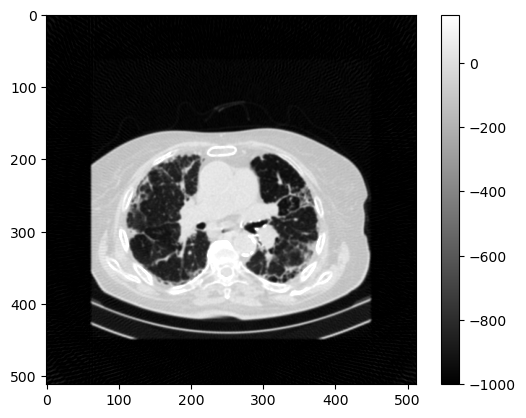

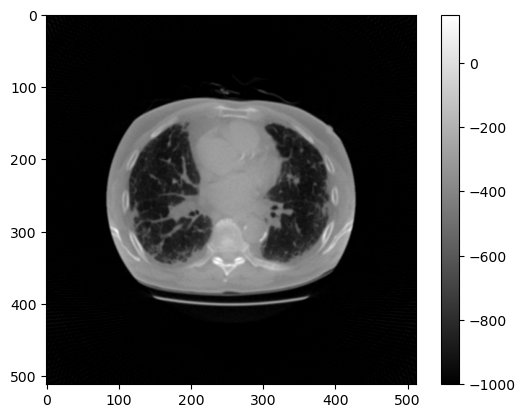

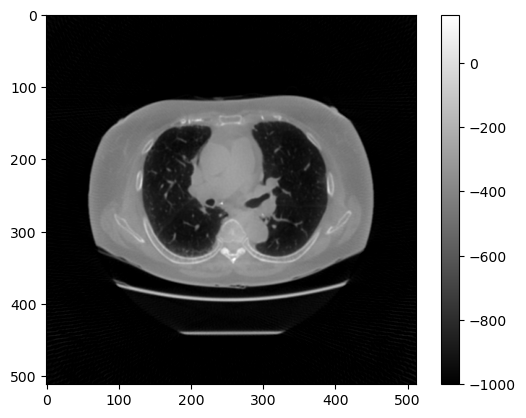

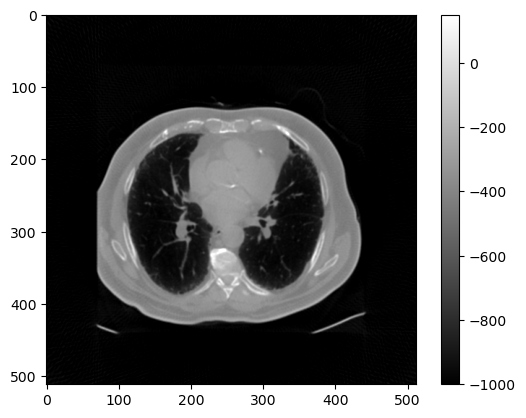

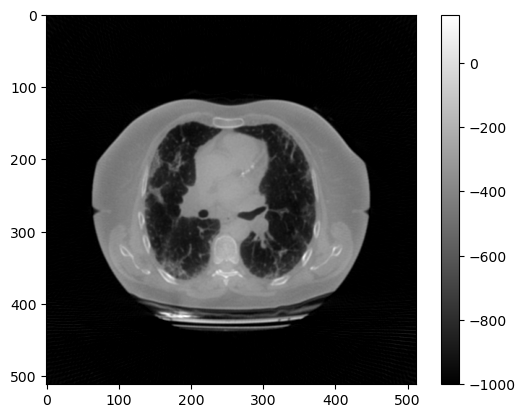

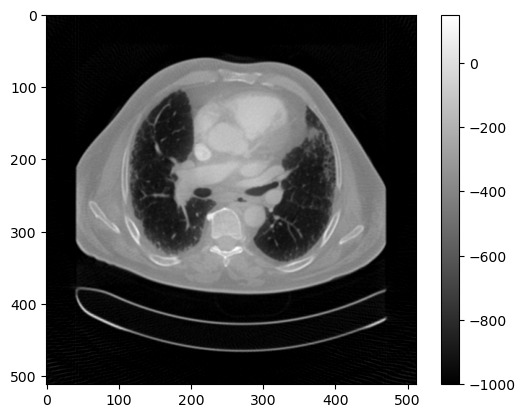

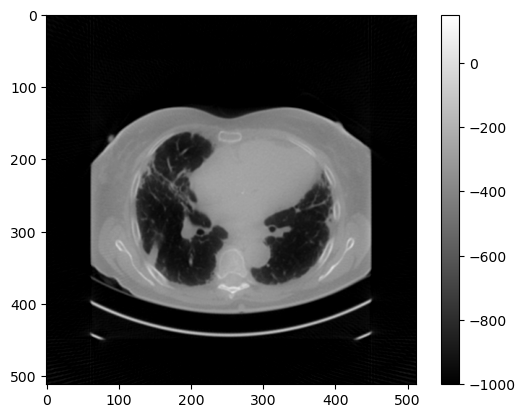

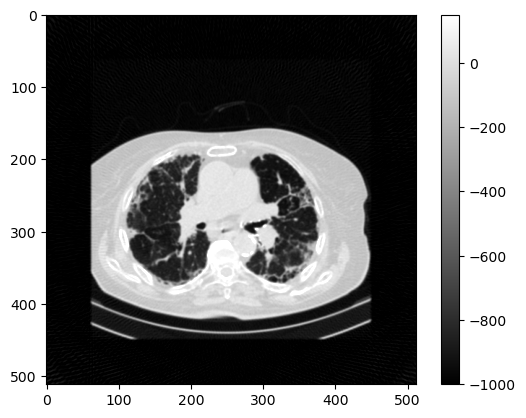

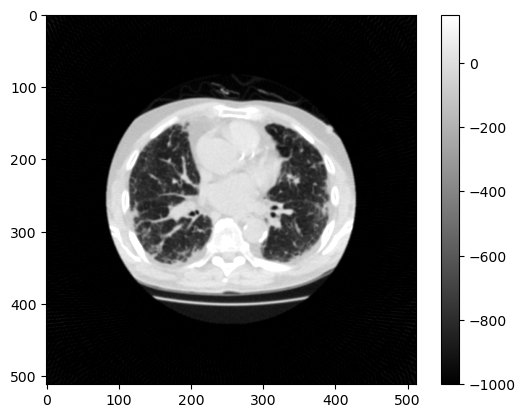

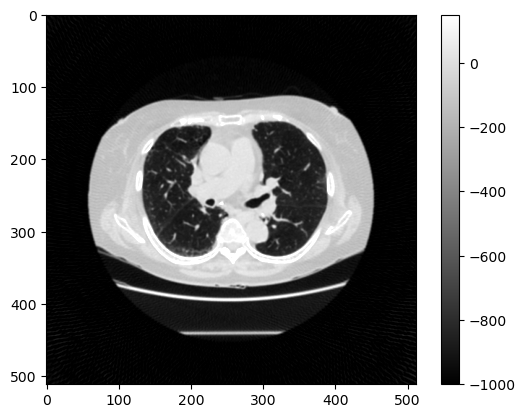

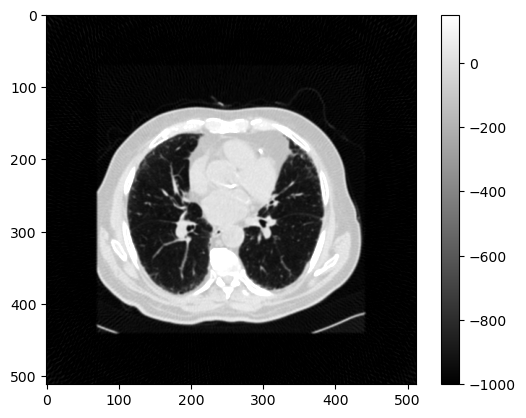

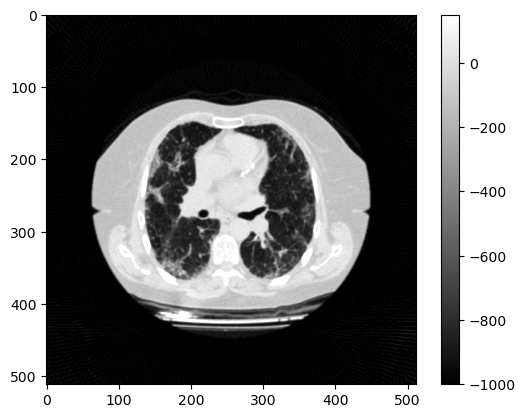

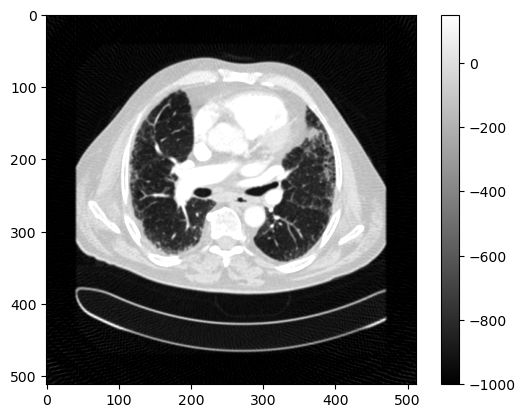

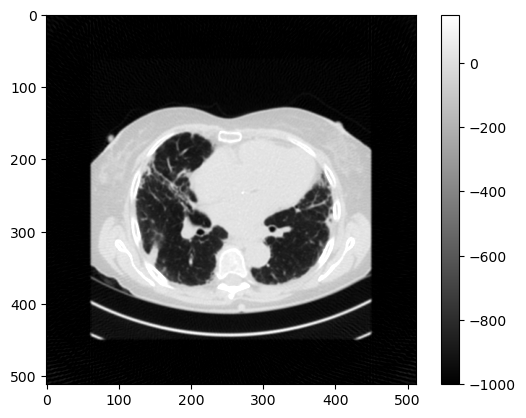

In [38]:
import matplotlib.pylab as plt
for img in scatter:
    plt.figure()
    plt.imshow(img[0],cmap = 'grey', vmin = -1000, vmax = 150)
    plt.colorbar()

In [ ]:
#sino = me, me = mse, mse = sino

In [17]:
img_list = [ref[0], scatter[2], sino[2], mseee[2], me[2]]

In [19]:
from scipy.ndimage import map_coordinates

def extract_line_profile(image, start_point, end_point, num_points=100):
    # Create an array of x and y coordinates along the line
    x = np.linspace(start_point[0], end_point[0], num_points)
    y = np.linspace(start_point[1], end_point[1], num_points)

    # Extract the intensity values along the line using interpolation
    line_profile = map_coordinates(image, [y, x])
    
    return line_profile

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


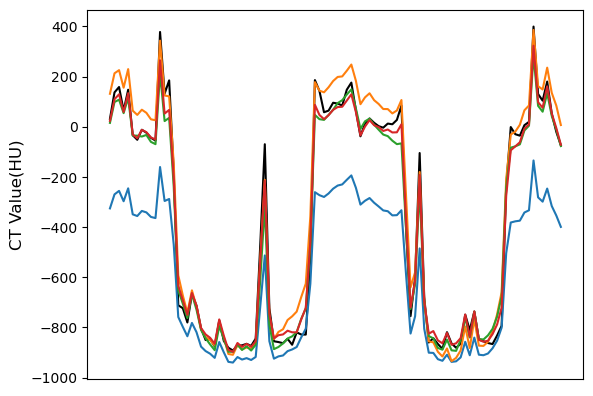

In [52]:
plt.figure()
for index,image in enumerate(img_list):
    profile = extract_line_profile(image[0][10:470,45:465], (57, 285), (368, 285))
    if index == 0:
        plt.plot(profile, color='black') 
    elif index == 5:
        plt.plot(profile, color='red') # First line in red
    else:
        plt.plot(profile)

# plt.title('Line 2')

plt.ylabel('CT Value(HU)',fontname='Arial', fontsize=12)
plt.gca().xaxis.set_visible(False)
# plt.legend(['Reference', 'Input', 'direct siongram denoising', 'Sinogram wavelet mapping', 'Weighted sinogram wavelet mapping'],loc='upper left', bbox_to_anchor=(1, 1))  # Update legend accordingly
plt.show()

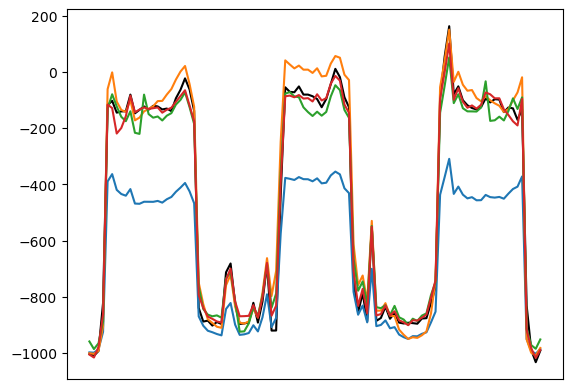

In [27]:
plt.figure()
for index, image in enumerate(img_list):
    profile = extract_line_profile(image[0][10:470,45:465], (19, 161), (402, 161))
    if index == 0:
        plt.plot(profile, color='black') 
    elif index == 5:
        plt.plot(profile, color='red') # First line in red
    else:
        plt.plot(profile) 

# plt.title('Line 1')

# plt.ylabel('CT Value(HU)')
plt.gca().xaxis.set_visible(False)
# plt.legend(['Reference', 'Input', 'SWU', 'WWU', 'Megatron'],loc='upper left', bbox_to_anchor=(1, 1))  # Update legend accordingly
plt.show()

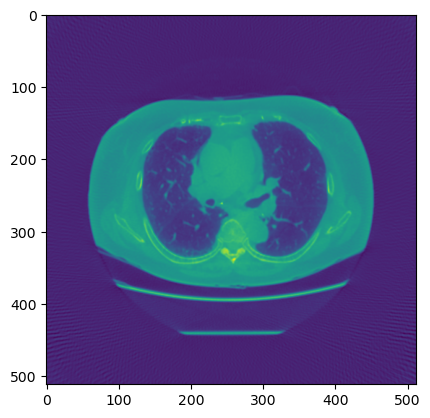

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Creating a dummy image for demonstration; replace this with your image loading code
image = scatter[2]
  # Drawing a red square in the middle

fig, ax = plt.subplots()
imgplot = ax.imshow(image[0])

def onclick(event):
    ix, iy = event.xdata, event.ydata
    print(f'x = {ix}, y = {iy}')

# Connection string to connect the click event with the onclick function
cid = fig.canvas.mpl_connect('button_press_event', onclick)


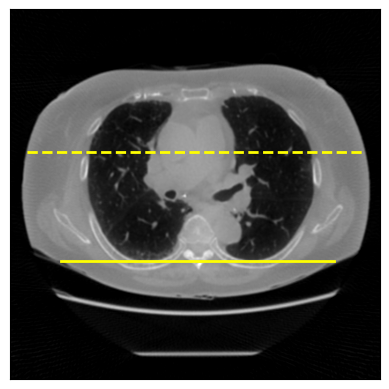

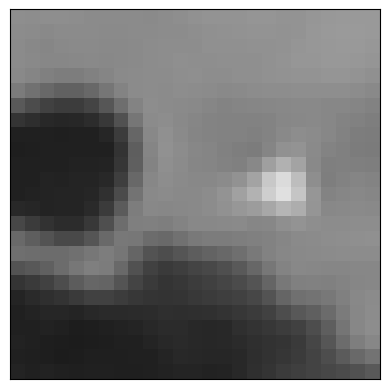

In [49]:
import matplotlib.patches as patches
img = scatter[2]
# cv2.line(img, start_point, end_point, color, thickness)
start_point = (250, 150)  # Top left corner
end_point = (350, 250)

fig, ax = plt.subplots()
cax = ax.imshow(img[0][50:470,45:465], cmap = "grey",vmin = -1000, vmax = 150, )
# rectangle = patches.Rectangle(start_point, end_point[0] - start_point[0], end_point[1] - start_point[1], edgecolor='b', facecolor="none")
# ax.add_patch(rectangle)
ax.plot([57, 368], [ 285, 285], color='yellow',linewidth=2) 
ax.plot([19, 402], [161, 161], color='yellow', linestyle='--',linewidth=2)  # Plotting the line
# # cbar = fig.colorbar(cax, pad=0.005,location='left') 
ax.set_xticks([])
ax.set_yticks([]) # Reduce pad to move colorbar closer
plt.show()


fig, ax = plt.subplots()
cax = ax.imshow(img[0,250:275,225:250], cmap = "grey",vmin = -1000, vmax = 150)
# cbar = fig.colorbar(cax, pad=0.005) 
ax.set_xticks([])
ax.set_yticks([]) # Reduce pad to move colorbar closer
plt.show()

In [53]:
from skimage.metrics import structural_similarity
from skimage.metrics import mean_squared_error
import numpy as np

def compute_metrics(original, processed):
    # Assuming original and processed are 3D numpy arrays of the same shape
    slices = original.shape[0]
    
    mse_values = []
    ssim_values = []
    
    # Determine the data range for floating-point images
    data_range = original.max() - original.min()  # This assumes both images have the same scale
    
    for i in range(slices-1):
        slice_original = original[ i,:, :]
        slice_processed = processed[ i,:, :]
        
        # Compute MSE for the current slice
        mse_slice = mean_squared_error(slice_original, slice_processed)
        mse_values.append(mse_slice)
        
        # Compute SSIM for the current slice, including the data_range
        ssim_slice = structural_similarity(slice_original, slice_processed, data_range=data_range)
        ssim_values.append(ssim_slice)
   

# Assuming image_actual and image_predicted are your 3D images represented as NumPy arrays.
# For example, they could be initialized like this with random values for demonstration:
# image_actual = np.random.rand(128, 128, 64)
# image_predicted = np.random.rand(128, 128, 64)

# Calculate NMSE
    numerator = np.sum((original - processed) ** 2)
    denominator = np.sum(original ** 2)

    nmse = numerator / denominator
    rmse = np.sqrt(np.mean((original - processed) ** 2))
 

    mae = np.mean(np.abs(original - processed))
    # Average MSE and SSIM over all slices
    ssim = np.std(ssim_values)
    mse_avg = np.mean(mse_values)
    ssim_avg = np.mean(ssim_values)
    
    # Compute PSNR for the entire 3D dataset, using the average MSE
    max_pixel_value = data_range  # Adjusted to use the calculated data range
    psnr_avg = 20 * np.log10(max_pixel_value / np.sqrt(mse_avg))
    
    return nmse, 100*ssim_avg, psnr_avg, rmse, mae

In [55]:
mse_ = []
ssim_ = []
psnr_ = []
rmse_ = []
mae_ = []
for a, b in zip(ref[1:], scatter[1:]):
    mse, ssim, psnr , rmse ,mae= compute_metrics(a, b)
    mse_.append(mse)
    ssim_.append(ssim)
    psnr_.append(psnr)
    rmse_.append(rmse)
    mae_.append(mae)
print(f"MSE: {np.mean(mse_),np.std(mse_)}, SSIM: {np.mean(ssim_),np.std(ssim_)}, PSNR: {np.mean(psnr_),np.std(psnr_)}, RMSE: {np.mean(rmse_),np.std(rmse_)}, mae: {np.mean(mae_),np.std(mae_)}")


MSE: (0.045040265, 0.007857934), SSIM: (75.0644497238074, 4.50946197058747), PSNR: (22.484861411659, 1.6848098298742662), RMSE: (174.73076, 8.879887), mae: (105.13369, 11.79409)
